# Анализ дорожно-транспортных происшествий в России (полные данные)

## Описание проекта
В этом ноутбуке мы повторяем анализ из `02_exploratory_analysis_sample.ipynb`, но на полном наборе данных. Данный проект представляет собой разведочный анализ данных о ДТП в России. Целью является выявление ключевых тенденций, распределения аварий по регионам, времени и условиям, а также оценка тяжести происшествий. Анализ основан на выборочных очищенных данных, предоставленных для воспроизводимости без использования облачных источников.

## Цели анализа
- Изучить динамику числа ДТП и погибших за несколько лет.
- Проанализировать распределение аварий по регионам, времени суток, погодным условиям, участникам и пр.
- Оценить связь факторов (тип ДТП, возраст транспорта, нарушения) и тяжесть происшествий.

## Структура данных
- `accidents`: Основной набор данных о ДТП, включая дату, регион, тип и тяжесть.
- `participants`: Данные об участниках происшествий, включая роль и нарушения.
- `vehicles`: Информация о транспортных средствах, включая возраст и категорию.
- Визуализации сохраняются в папке `../outputs/figures/`. Статические — в формате PNG, интерактивные — в формате HTML.
- Данные скачиваются с Яндекс.Диска, сохраняются в SQLite-базу `../data/crash_database.db`

## Источники данных
см. `../README.md`

In [24]:
# Загрузка библиотек и утилит
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys

sys.path.append(os.path.abspath("../scripts")) # Добавляем путь к скриптам

from utils import (
    load_full_data_to_sqlite,
    run_query,
    save_png,
    save_html
)

# Пути для сохранения визуализаций
FIG_DIR = "../outputs/figures"
FIG_INT_DIR = "../outputs/figures/interactive"

# Загрузка данных
В следующей ячейке мы загружаем файлы из облака в базу данных SQLite для оптимизации работы кода

In [4]:
#%% Загрузка данных в SQLite
accidents_url    = "https://disk.yandex.ru/d/yPdgwafR_2xElg"
participants_url = "https://disk.yandex.ru/d/YeyKLfXuETaEUQ"
vehicles_url     = "https://disk.yandex.ru/d/NJApFGWb85CWVQ"

conn = load_full_data_to_sqlite(
    accidents_url,
    participants_url,
    vehicles_url,
    db_path="../data/crash_database.db"
)

готово


# Динамика числа ДТП по годам и месяцам

## Описание задачи

Следующая ячейка анализирует многолетнюю динамику числа дорожно-транспортных происшествий (ДТП) в России на основе выборочных данных. Цель — выявить тенденции изменения количества аварий и погибших по месяцам и годам.

## Данные

Используются данные из таблицы `accidents`, агрегированные по годам и месяцам с расчётом общего числа ДТП и погибших.

In [63]:
# Динамика числа ДТП по годам и месяцам (интерактивно)
import sys, os
import plotly.graph_objects as go
from utils import run_query, save_html

# SQL-запрос: месячная агрегация
sql_monthly = """
SELECT
  CAST(strftime('%Y', datetime) AS INTEGER) AS year,
  CAST(strftime('%m', datetime) AS INTEGER) AS month,
  COUNT(*)                                 AS accident_count,
  SUM(dead_count)                          AS dead_count
FROM accidents
GROUP BY year, month
ORDER BY year, month
"""
monthly_stats = run_query(conn, sql_monthly)

# готовим подписи для оси X — первый месяц каждого года
time_labels   = []
tick_positions = []
current_year  = None
for i, (y, m) in enumerate(zip(monthly_stats["year"], monthly_stats["month"])):
    if y != current_year:
        time_labels.append(f"{y}-{m:02d}")
        tick_positions.append(i)
        current_year = y

# строим интерактивный график
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(len(monthly_stats))),
    y=monthly_stats["accident_count"],
    mode="lines+markers",
    name="Число ДТП",
    line=dict(color="blue", width=2),
    marker=dict(size=6)
))

# вертикальные линии разделения годов
for pos in tick_positions[1:]:
    fig.add_shape(
        type="line",
        x0=pos, y0=0,
        x1=pos, y1=monthly_stats["accident_count"].max(),
        line=dict(color="gray", width=1, dash="dash")
    )

# оформление
fig.update_layout(
    title="Динамика числа ДТП по годам и месяцам",
    xaxis_title="Год–месяц",
    yaxis_title="Число ДТП",
    xaxis=dict(
        tickmode="array",
        tickvals=tick_positions,
        ticktext=time_labels,
        tickangle=0
    ),
    yaxis=dict(showgrid=True, gridcolor="#e0e0e0"),
    width=800,
    height=400
)

fig.show()

# сохраняем в HTML для интерактивного просмотра
save_html(fig, os.path.join(FIG_INT_DIR, "monthly_accidents.html"))

Query returned 113 rows


## Выводы

- За рассматриваемый период (2015–2024) наблюдается тенденция к постепенному снижению общего числа ДТП.
- Аварийность демонстрирует серьезные сезонные колебания.
- Больше всего аварий приходится на июль-сентябрь, а меньше всего на февраль-май.

# Распределение ДТП по месяцам

В этом блоке мы:
- С помощью SQL извлекаем из базы число ДТП и сумму погибших по годам и месяцам;
- С помощью `calendar.monthrange` определяем число дней в каждом месяце;
- Вычисляем среднее число ДТП в день для каждого месяца с учётом разной длины месяцев;
- Агрегируем результаты по месяцам календарного года, чтобы получить среднее дневное число ДТП в январе, феврале и т.д.;
- Строим полярный график, где угловая координата соответствует месяцу, а радиальная — среднему числу ДТП в день. Сохраняем результат в PNG.

Query returned 113 rows


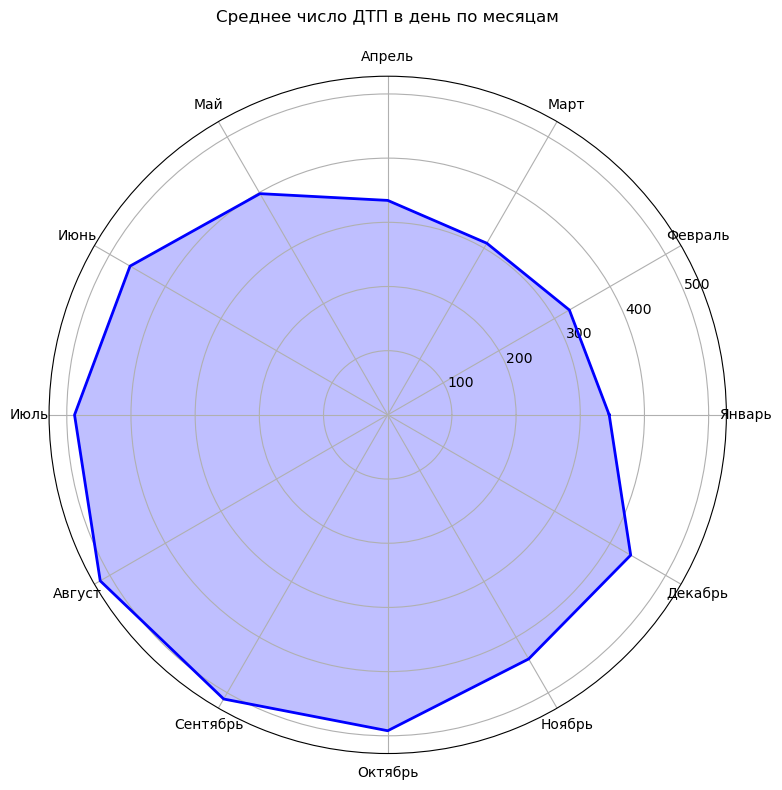

In [66]:
import calendar
from utils import run_query, save_png
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Извлекаем месячную статистику из SQLite
sql_monthly = """
SELECT
  CAST(strftime('%Y', datetime) AS INTEGER) AS year,
  CAST(strftime('%m', datetime) AS INTEGER) AS month,
  COUNT(*)                                    AS accident_count,
  SUM(dead_count)                             AS dead_count
FROM accidents
GROUP BY year, month
ORDER BY year, month
"""
monthly_stats = run_query(conn, sql_monthly)

# Считаем число дней в каждом месяце
monthly_stats['days_per_month'] = monthly_stats.apply(
    lambda r: calendar.monthrange(r.year, r.month)[1],
    axis=1
)

# Рассчитываем среднедневное число ДТП в каждом месяце
monthly_stats['accidents_per_day'] = (
    monthly_stats['accident_count'] / monthly_stats['days_per_month']
).round(3)

# Сортируем по году и месяцу
monthly_stats = (
    monthly_stats
    .sort_values(['year', 'month'])
    .reset_index(drop=True)
)

# Агрегируем по календарному месяцу
weighted_data = (
    monthly_stats
    .groupby('month', as_index=False)
    .agg(
        total_accidents=('accident_count', 'sum'),
        total_days      =('days_per_month', 'sum')
    )
)
weighted_data['avg_daily_accident'] = (
    weighted_data['total_accidents'] / weighted_data['total_days']
).round(3)

# Строим радиальную диаграмму
# Константы для стилей
FIGURE_SIZE = (8, 8)
LINE_COLOR = "blue"
LINE_WIDTH = 2
FILL_ALPHA = 0.25
FONT_SIZE = 10

# Русские названия месяцев
month_names_ru = {
    1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
    5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
    9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
}

# Подготовка данных для графика
month_labels = [month_names_ru[m] for m in weighted_data["month"]]
daily_accidents = weighted_data["avg_daily_accident"].tolist()

# Закрытие круга
angles = np.linspace(0, 2 * np.pi, len(month_labels), endpoint=False).tolist()
daily_accidents.append(daily_accidents[0])
angles.append(angles[0])

# Построение полярной диаграммы
fig, ax = plt.subplots(figsize=FIGURE_SIZE, subplot_kw={"projection": "polar"})
ax.plot(angles, daily_accidents, color=LINE_COLOR, linewidth=LINE_WIDTH)
ax.fill(angles, daily_accidents, color=LINE_COLOR, alpha=FILL_ALPHA)

# Настройка подписей и заголовка
ax.set_xticks(angles[:-1])
ax.set_xticklabels(month_labels, fontsize=FONT_SIZE)
ax.set_title("Среднее число ДТП в день по месяцам", fontsize=12, pad=20)

# Сохраняем результат
save_png(fig, f"{FIG_DIR}/avg_daily_accidents_polar.png")

## Выводы

- **Периоды пиковой аварийности**: Наибольшее количество аварий наблюдается в период с **июля по сентябрь**.
- **Периоды минимальной аварийности**: Наименьшее количество аварий приходится на **февраль-май**, что может быть обусловлено снижением транспортной активности или снижением средней скорости движения транспортных средств.

## Распределение ДТП по часам суток (интерактивно)

В этом блоке мы выполняем SQL-запрос к базе, чтобы получить число аварий по каждым часам суток, а затем строим интерактивный линейный график через утилиту `plotly_line_chart` из `utils.py`.

In [69]:
import sys, os
import plotly.express as px
from utils import run_query, plotly_line_chart, save_html

# SQL-запрос: аварии по часам суток
sql_hours = """
SELECT
  CAST(strftime('%H', datetime) AS INTEGER) AS hour,
  COUNT(*)                                   AS accident_count
FROM accidents
GROUP BY hour
ORDER BY hour
"""
accidents_by_hour = run_query(conn, sql_hours)

# Строим интерактивный линейный график
fig = px.line(
    accidents_by_hour,
    x='hour',
    y='accident_count',
    title='Распределение ДТП по часам суток',
    labels={'hour':'Час суток','accident_count':'Число ДТП'}
)
fig.update_traces(mode='lines+markers')
fig.update_layout(xaxis_tickmode='array', xaxis_tickvals=accidents_by_hour['hour'])
# сохраним интерактивный html
save_html(fig, f"{FIG_INT_DIR}/accidents_by_hour.html")
# и покажем
fig.show()

Query returned 24 rows


## Выводы
- **Неравномерное распределение ДТП** по времени суток: пики в часы пик, минимум ночью.
- **Основные тренды**:
  - Ночью (0:00–5:00) аварий почти нет — низкий трафик.
  - С 6:00 резкий рост, пик в 8:00 (утренний час пик).
  - Небольшой спад к 9:00, затем рост до максимума в 17:00–18:00 (вечерний час пик).
  - После 19:00 — быстрое снижение.

## Погибшие на одно ДТП по годам (интерактивно)

В этом блоке мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить по годам количество аварий и суммарное число погибших;
- Вычисляем показатель «погибших на одно ДТП»;
- Сохраняем результат в HTML для просмотра в браузере.

In [72]:
import sys, os
import plotly.express as px
from utils import run_query, save_html

# добавляем путь к utils.py
sys.path.append(os.path.abspath("../scripts"))

# директория для интерактивных графиков
FIG_DIR_INT = os.path.join("figures", "interactive")
os.makedirs(FIG_DIR_INT, exist_ok=True)

# SQL-запрос: агрегируем число ДТП и погибших по годам
sql = """
SELECT
  CAST(strftime('%Y', datetime) AS INTEGER) AS year,
  COUNT(*)                                   AS accident_count,
  SUM(dead_count)                            AS death_count
FROM accidents
GROUP BY year
ORDER BY year
"""
severity_by_year = run_query(conn, sql)

# рассчитываем погибших на одно ДТП
severity_by_year['deaths_per_accident'] = (
    severity_by_year['death_count'] / severity_by_year['accident_count']
)

# индексы для оси X
idx = list(range(len(severity_by_year)))

# строим интерактивный график
fig = px.line(
    x=idx,
    y=severity_by_year['deaths_per_accident'],
    markers=True,
    title='Погибшие на одно ДТП по годам'
)
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=idx,
        ticktext=severity_by_year['year'].astype(str).tolist()
    ),
    xaxis_title='Год',
    yaxis_title='Погибших на одно ДТП',
    template='simple_white'
)

# сохраняем интерактивный HTML
output_path = os.path.join(FIG_INT_DIR, "deaths_per_accident_by_year.html")
save_html(fig, output_path)

# показываем в ноутбуке
fig.show()

Query returned 10 rows


## Выводы
- **Общая аварийность**: Количество ДТП за период снижалось.
- **Тяжесть ДТП** (доля погибших на одно ДТП):
  - **2015–2019**: Постепенное снижение показателя.
  - **2020**: Резкий рост, почти до уровня 2017 года.
  - **2021–2022**: Стабильный уровень без значительных изменений.
  - **2023**: Небольшое снижение.

## Тяжесть ДТП по регионам для 2015 и 2023 годов

В этом блоке мы сравним смертность на одно ДТП по регионам в двух ключевых годах (2015 и 2023). Данные фильтруем прямо в SQL по полю `datetime`, извлекая год через `strftime`. Затем для каждого года строим горизонтальные гистограммы и сохраняем их в `figures/`.

Query returned 85 rows


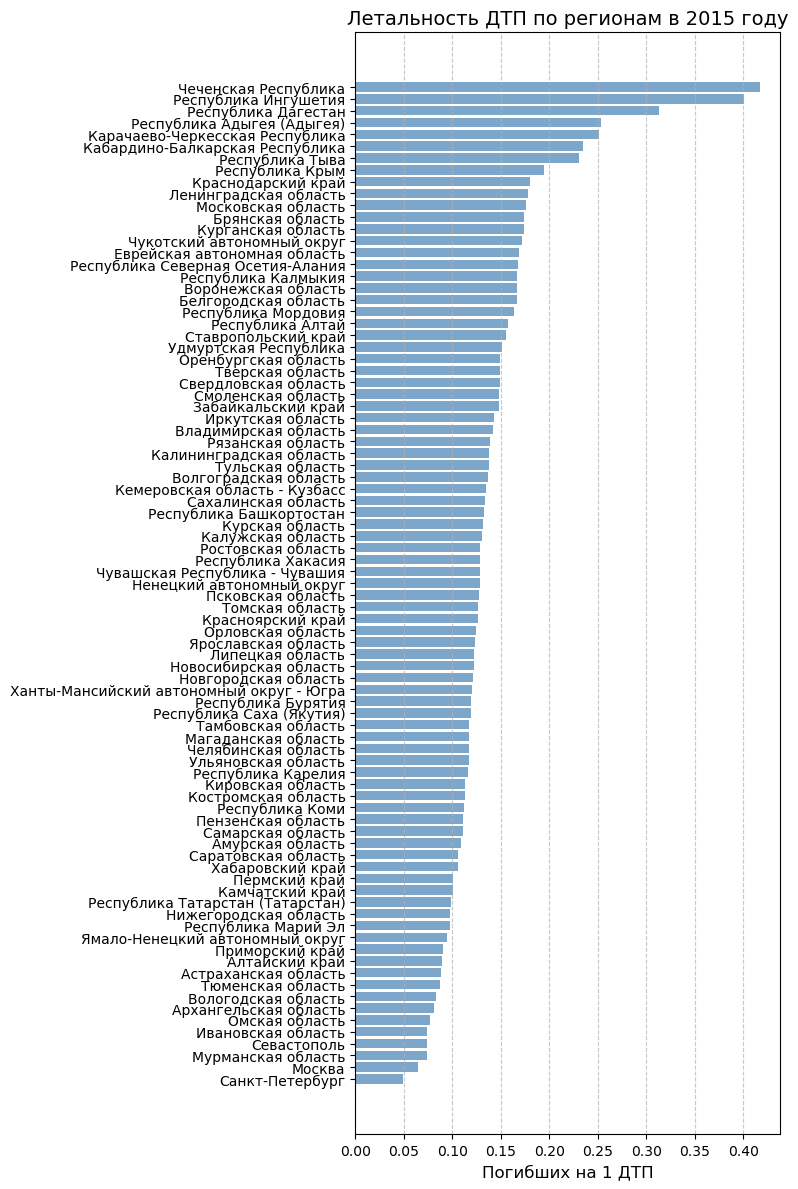

Query returned 83 rows


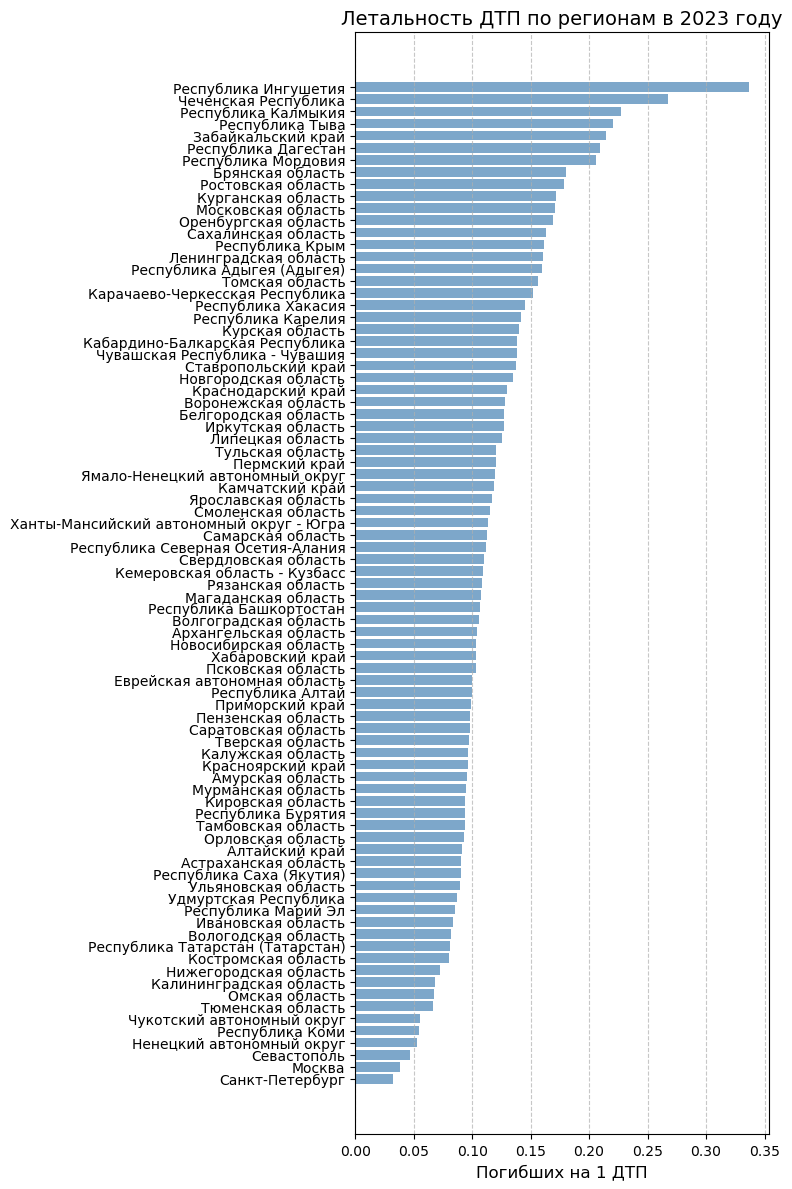

In [75]:
import sys, os
import matplotlib.pyplot as plt

# подключаем утилиты
sys.path.append(os.path.abspath("../scripts"))
from utils import run_query, compute_rate, save_png
os.makedirs(FIG_DIR, exist_ok=True)

for yr in (2015, 2023):
    # SQL-запрос с фильтрацией по году через strftime
    sql = f"""
    SELECT
      region,
      COUNT(*)        AS accident_count,
      SUM(dead_count) AS death_count
    FROM accidents
    WHERE CAST(strftime('%Y', datetime) AS INTEGER) = {yr}
    GROUP BY region
    """
    df = run_query(conn, sql)

    # считаем погибших на одно ДТП
    df = compute_rate(
        df,
        numerator   = 'death_count',
        denominator = 'accident_count',
        new_col     = 'deaths_per_accident',
        multiplier  = 1
    ).sort_values('deaths_per_accident', ascending=False).reset_index(drop=True)

    # строим горизонтальную гистограмму
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.barh(
        df['region'],
        df['deaths_per_accident'],
        color='steelblue',
        alpha=0.7
    )
    ax.invert_yaxis()
    ax.set_title(f'Летальность ДТП по регионам в {yr} году', fontsize=14)
    ax.set_xlabel('Погибших на 1 ДТП', fontsize=12)
    ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # сохраняем результат
    save_png(fig, os.path.join(FIG_DIR, f'fatality_by_region_{yr}.png'))
    plt.show()

**Тяжесть ДТП по регионам** (число погибших на одно ДТП):
  - **2015 и 2023**: Минимальная тяжесть последствий — в городах федерального значения.
  - **2015 и 2023**: Максимальная тяжесть — в республиках Северного Кавказа.
- **Динамика лидеров по тяжести**:
  - **2015**: Лидировали Чеченская Республика и Ингушетия, за ними — другие республики Северного Кавказа.
  - **2023**: Позиции Чечни и Ингушетии улучшились, их место заняли Калмыкия, Тыва и Забайкальский край.

## Карта числа ДТП по регионам

В этом блоке мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить число ДТП по каждому региону в 2021 году (год переписи населения);
- Загружаем GeoJSON с границами регионов и объединяем его с результатами через `load_and_merge_geodata` из `utils.py`;
- Строим хлороплетную карту через GeoPandas/Matplotlib;
- Сохраняем итоговую визуализацию в `figures/accidents_by_region_map.png`.

Query returned 85 rows


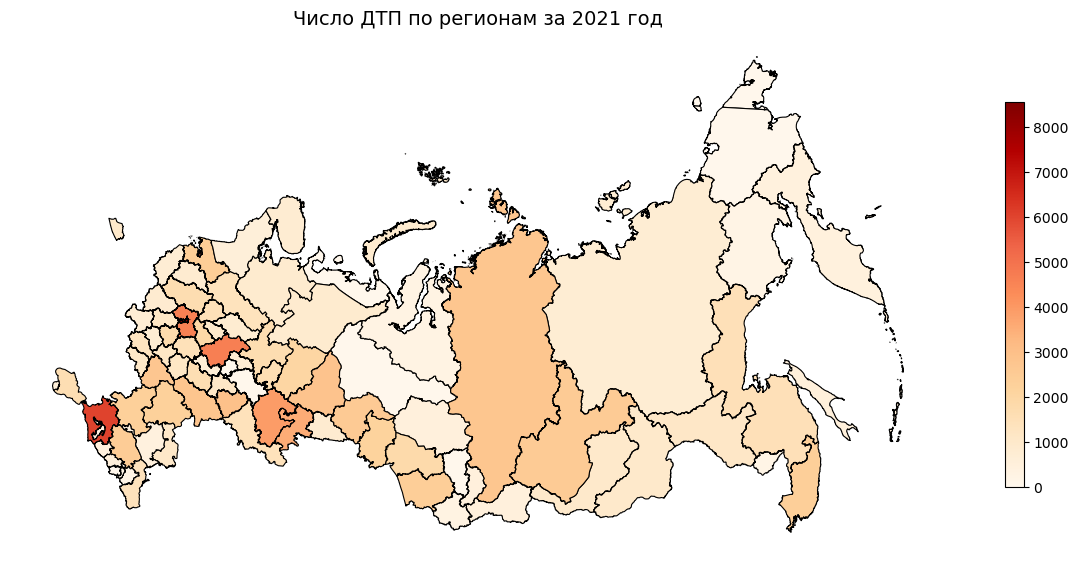

In [78]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, load_and_merge_geodata, save_png

# SQL-запрос: число ДТП по регионам в 2021 году
sql_2021 = """
SELECT
  region,
  COUNT(*) AS accident_number
FROM accidents
WHERE CAST(strftime('%Y', datetime) AS INTEGER) = 2021
GROUP BY region
"""
region_accidents_2021 = run_query(conn, sql_2021)

# объединяем с геоданными
geofile = "../data/russia_regions.geojson"
regions_gdf_2021 = load_and_merge_geodata(
    geofile_path   = geofile,
    accidents_data = region_accidents_2021,
    region_col     = "region"
)

# строим карту
fig, ax = plt.subplots(figsize=(12, 8))
regions_gdf_2021.plot(
    column       = "accident_number",
    cmap         = "OrRd",
    linewidth    = 0.8,
    edgecolor    = "black",
    legend       = True,
    ax           = ax,
    legend_kwds  = {"shrink": 0.5},
    missing_kwds = {"color": "lightgrey"}
)
ax.set_title("Число ДТП по регионам за 2021 год", fontsize=14)
ax.axis("off")
plt.tight_layout()

# сохраняем
save_png(fig, os.path.join(FIG_DIR, "accidents_by_region_2021.png"))
plt.show()

## Выводы

### 1. Высокая концентрация ДТП в западной части страны
- Наибольшее число ДТП наблюдается в **Московской области** и прилегающих регионах (более 8000 случаев).
- Также выделяются **Краснодарский край**, **Ростовская область**, **Ставропольский край** — регионы с высокой численностью населения и развитой дорожной инфраструктурой.
- Это отражает корреляцию между интенсивностью трафика и числом происшествий.

### 2. Средняя интенсивность ДТП в Поволжье и на Урале
- Умеренное число ДТП зафиксировано в регионах с развитой промышленностью и логистикой: **Татарстан**, **Башкортостан**, **Самарская область**, **Свердловская область**.
- Эти регионы характеризуются активным автомобильным движением, но при этом не столь высокими пиками, как в центральной части России.

### 3. Низкие значения в Сибири и на Дальнем Востоке
- Регионы вроде **Якутии**, **Чукотки**, **Магаданской области**, **Забайкальского края** имеют низкое число ДТП.
- Это связано с низкой численностью населения, слаборазвитой дорожной сетью и ограниченным трафиком на больших расстояниях.

## Карта социального риска: ДТП на 100 000 человек населения за 2021 год

В этом блоке мы:
- Фильтруем аварии по году 2021 (год последней переписи населения);
- Считаем число ДТП по каждому региону за 2021 год;
- Объединяем результаты с геоданными через `load_and_merge_geodata`;
- Рассчитываем число ДТП на 100 000 человек;
- Строим статическую хлороплетную карту и сохраняем её в PNG.

Query returned 85 rows


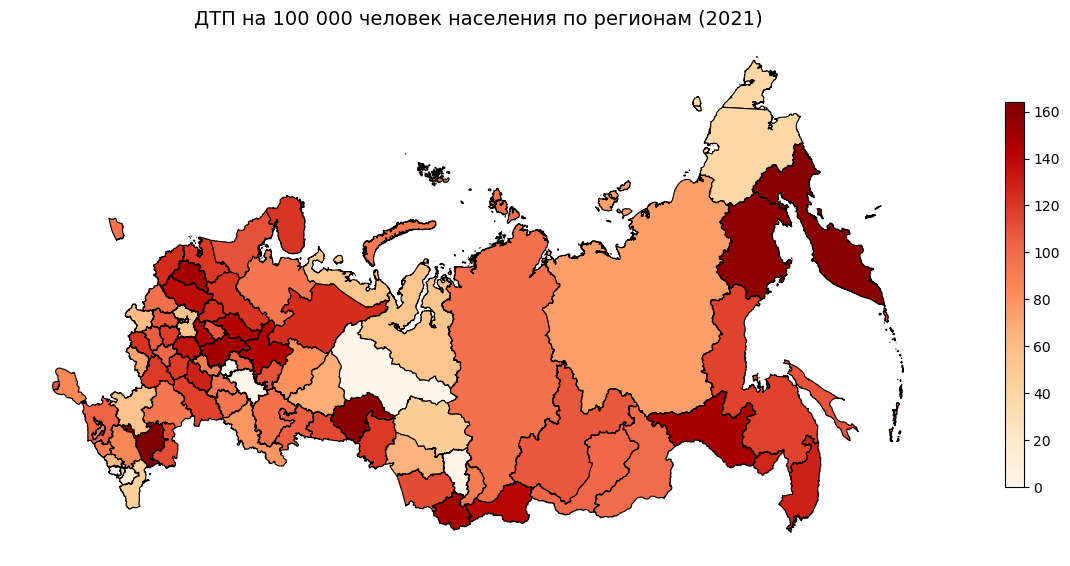

In [81]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, load_and_merge_geodata, save_png

# SQL: число ДТП по регионам в 2021 году
sql_2021 = """
SELECT
  region,
  COUNT(*) AS accident_number
FROM accidents
WHERE CAST(strftime('%Y', datetime) AS INTEGER) = 2021
GROUP BY region
"""
region_accidents_2021 = run_query(conn, sql_2021)

# Объединение с геоданными
geofile = "../data/russia_regions.geojson"
regions_gdf_2021 = load_and_merge_geodata(
    geofile_path   = geofile,
    accidents_data = region_accidents_2021,
    region_col     = "region"
)

# Отбрасываем регионы с нулевой популяцией
regions_gdf_2021 = regions_gdf_2021[regions_gdf_2021["population"] > 0].copy()

# Рассчитываем ДТП на 100 000 человек
regions_gdf_2021["accidents_per_100k"] = (
    regions_gdf_2021["accident_number"]
    / regions_gdf_2021["population"]
    * 100_000
)

# Строим карту социального риска
fig, ax = plt.subplots(figsize=(12, 8))
regions_gdf_2021.plot(
    column       = "accidents_per_100k",
    cmap         = "OrRd",
    linewidth    = 0.8,
    edgecolor    = "black",
    legend       = True,
    ax           = ax,
    legend_kwds  = {"shrink": 0.5},
    missing_kwds = {"color": "lightgrey"}
)
ax.set_title("ДТП на 100 000 человек населения по регионам (2021)", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Сохраняем результат
save_png(fig, os.path.join(FIG_DIR, "social_risk_map_2021.png"))
plt.show()

## Выводы

### Повышенная аварийность на юге и востоке страны
- **Дальний Восток** (Камчатский край, Магаданская область, Амурская область), **Южная Сибирь** (Республика Тыва, Забайкальский край), а также **Северный Кавказ** демонстрируют максимальные значения показателя (более 120 ДТП на 100 тыс. человек).
- Это может быть связано с ограниченным числом современных дорог, климатическими условиями, а также спецификой междугороднего трафика.

### Умеренные значения в центре и на юге европейской части
- Большинство регионов Центрального и Южного федеральных округов (например, Воронежская, Липецкая, Волгоградская области) демонстрируют значения от 60 до 100.
- Несмотря на большое абсолютное число ДТП, численность населения в этих регионах снижает нормированный показатель.

### Относительно низкие показатели в регионах Севера и части Урала
- **Ямал**, **ХМАО**, **Архангельская область**, а также **Чукотка** и отдельные регионы Сибири имеют низкий уровень аварий на душу населения.
- Возможные причины: ограниченный автотрафик, малая плотность населения, при этом наличие высокие региональные доходы могут играть роль в обеспечении безопасности.

### Аномалии
- **Калмыкия**, **Севастополь**, **Еврейская АО**, **Тува** и **Камчатка** имеют чрезвычайно высокие значения при относительно малом населении — возможно, из-за высокой мобильности или методологических особенностей учёта.
- Некоторые регионы с высоким уровнем автомобилизации (например, Санкт-Петербург и Московская область) имеют более низкие значения, чем ожидалось — вероятно, из-за хорошей дорожной инфраструктуры и эффективной организации движения.

## Тяжесть ДТП по типам ДТП

В этом блоке мы:
- Через SQL получаем по каждому типу ДТП (`category`):
   - `accident_count` – число уникальных аварий;
   - `death_count`    – общее число погибших;
   - `participants_count` – общее число участников (из таблицы `participants`);
- С помощью `compute_rate` рассчитываем летальность `fatality_rate` = (число погибших / число участников) × 100;
- Выводим две таблицы:
   - топ-10 категорий по числу ДТП;
   - топ-10 категорий по уровню летальности.

In [84]:
import sys, os
from IPython.display import display
from utils import run_query, compute_rate

# SQL: агрегируем по типам ДТП
sql = """
SELECT
  a.category               AS category,
  COUNT(DISTINCT a.id)     AS accident_count,
  SUM(a.dead_count)        AS death_count,
  COUNT(p.accident_id)     AS participants_count
FROM accidents a
LEFT JOIN participants p
  ON a.id = p.accident_id
GROUP BY a.category
"""
severity_by_category = run_query(conn, sql)

# рассчитываем fatality_rate = (death_count / participants_count) * 100
severity_by_category = compute_rate(
    df          = severity_by_category,
    numerator   = 'death_count',
    denominator = 'participants_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# топ-10 по числу ДТП
top_by_count = severity_by_category.sort_values(
    by='accident_count', ascending=False
).head(10).reset_index(drop=True)

# топ-10 по уровню летальности
top_by_rate = severity_by_category.sort_values(
    by='fatality_rate', ascending=False
).head(10).reset_index(drop=True)

display(top_by_count)
display(top_by_rate)

Query returned 18 rows


,category,accident_count,death_count,participants_count,fatality_rate
0,Столкновение,614131,294101,1881397,15.6
1,Наезд на пешехода,412343,96210,850066,11.3
2,Опрокидывание,87481,31154,154456,20.2
3,Съезд с дороги,87126,27630,161065,17.2
4,Наезд на препятствие,85894,26852,153161,17.5
5,Наезд на велосипедиста,47706,7016,97137,7.2
6,Падение пассажира,46303,937,96814,1.0
7,Наезд на стоящее ТС,43033,19204,123881,15.5
8,Иной вид ДТП,6753,1844,11744,15.7
9,Наезд на животное,5123,1509,9795,15.4


,category,accident_count,death_count,participants_count,fatality_rate
0,"Наезд на лицо, не являющееся участником дорожн...",1027,395,1315,30.0
1,"Наезд на лицо, не являющееся участником дорожн...",660,231,847,27.3
2,Наезд на гужевой транспорт,248,145,652,22.2
3,Опрокидывание,87481,31154,154456,20.2
4,Наезд на препятствие,85894,26852,153161,17.5
5,Съезд с дороги,87126,27630,161065,17.2
6,Падение груза,280,123,723,17.0
7,Иной вид ДТП,6753,1844,11744,15.7
8,Столкновение,614131,294101,1881397,15.6
9,Наезд на стоящее ТС,43033,19204,123881,15.5


##Выводы

- **Основные типы ДТП**:
  - Столкновение двух ТС — лидер по количеству случаев.
  - Наезд на пешехода — значительная доля инцидентов.
  - Опрокидывание ТС — частый тип аварий.
- **Смертельные типы ДТП**:
  - Наибольшая смертность — в ДТП с одним ТС: наезды на пешеходов, съезды, опрокидывания, наезды на препятствия.
  - Меньше смертности — в столкновениях нескольких ТС.

## Число ДТП и летальность по состоянию освещения (статически)

В этом блоке мы:
- Через SQL получаем из базы общее число аварий и суммарное число погибших в разрезе состояний освещения (`light`);
- С помощью `compute_rate` рассчитываем летальность (`fatality_rate` = погибших на 1 ДТП);
- Строим два статических графика — сначала по числу ДТП, затем по летальности — и сохраняем их в `figures/`.

Query returned 6 rows


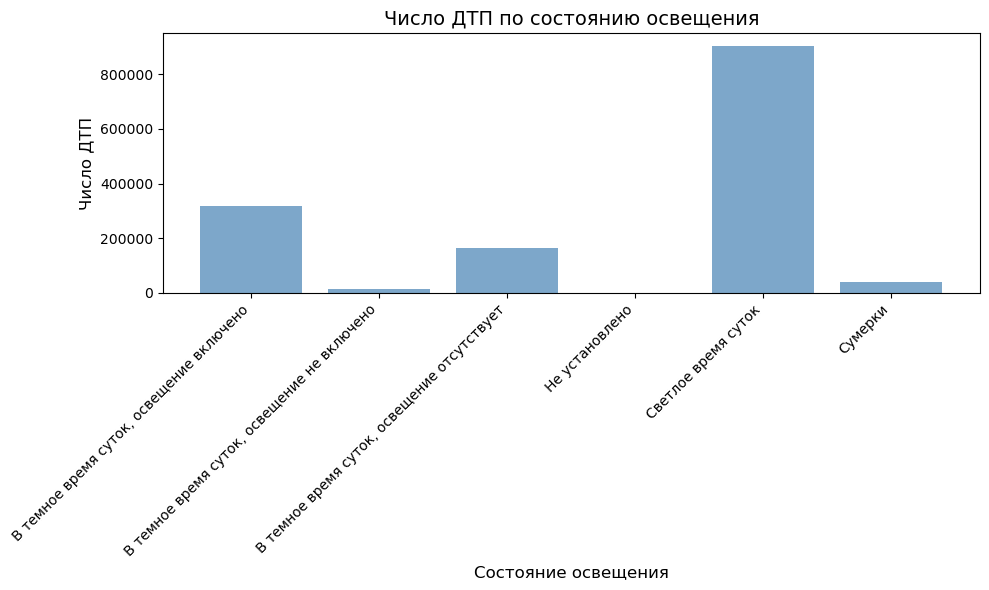

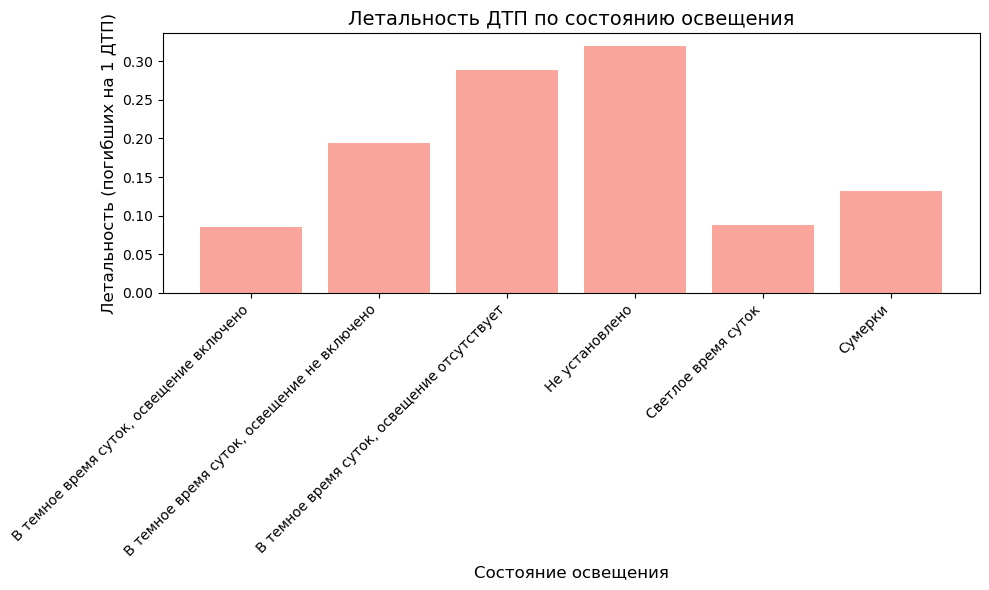

In [87]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, compute_rate, save_png

# Получаем данные из SQLite
sql = """
SELECT
  light,
  COUNT(*)       AS accident_count,
  SUM(dead_count) AS death_count
FROM accidents
GROUP BY light
"""
light_stats = run_query(conn, sql)

# Вычисляем летальность = погибших на 1 ДТП
light_stats = compute_rate(
    df          = light_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 1
)

# Гистограмма числа ДТП
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    light_stats['light'],
    light_stats['accident_count'],
    color='steelblue',
    alpha=0.7
)
ax.set_title('Число ДТП по состоянию освещения', fontsize=14)
ax.set_xlabel('Состояние освещения', fontsize=12)
ax.set_ylabel('Число ДТП', fontsize=12)
ax.grid(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_png(fig, os.path.join(FIG_DIR, 'accidents_by_light.png'))
plt.show()

# Гистограмма летальности ДТП
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    light_stats['light'],
    light_stats['fatality_rate'],
    color='salmon',
    alpha=0.7
)
ax.set_title('Летальность ДТП по состоянию освещения', fontsize=14)
ax.set_xlabel('Состояние освещения', fontsize=12)
ax.set_ylabel('Летальность (погибших на 1 ДТП)', fontsize=12)
ax.grid(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_png(fig, os.path.join(FIG_DIR, 'fatality_by_light.png'))
plt.show()

## Выводы
- **Распределение числа ДТП по условиям освещения**:
  - Большинство аварий происходит в светлое время или при включенном освещении.
- **Летальность по условиям освещения**:
  - ДТП при недостаточном освещении имеют более высокую относительную смертность.

## ДТП и летальность по погодным условиям (статически)

В этом блоке мы:
- Выполняем SQL-запрос к базе, чтобы получить по каждому состоянию погоды число ДТП и суммарное число погибших;
- С помощью `compute_rate` рассчитываем летальность (`fatality_rate` = погибших на 1 ДТП);
- Строим две гистограммы через `plot_bar_chart` из `utils.py` и сохраняем их в папку `figures/`.

Query returned 33 rows


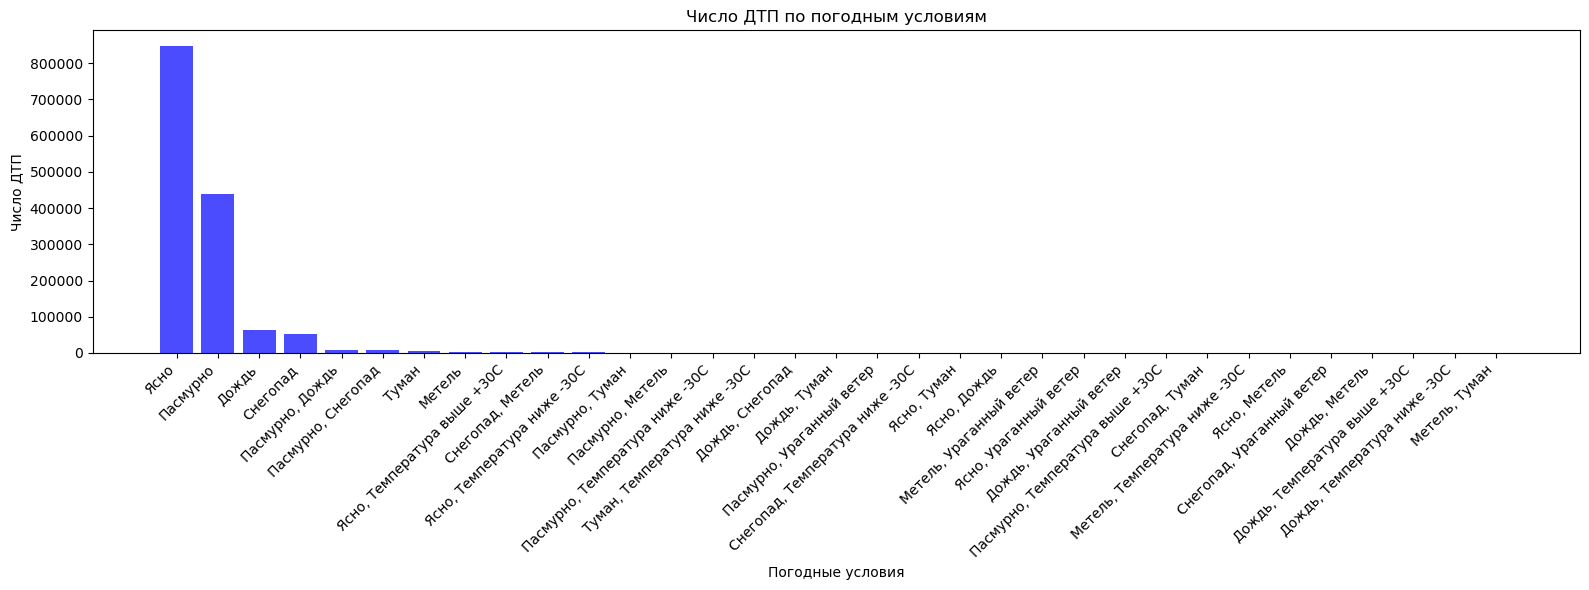

<Figure size 640x480 with 0 Axes>

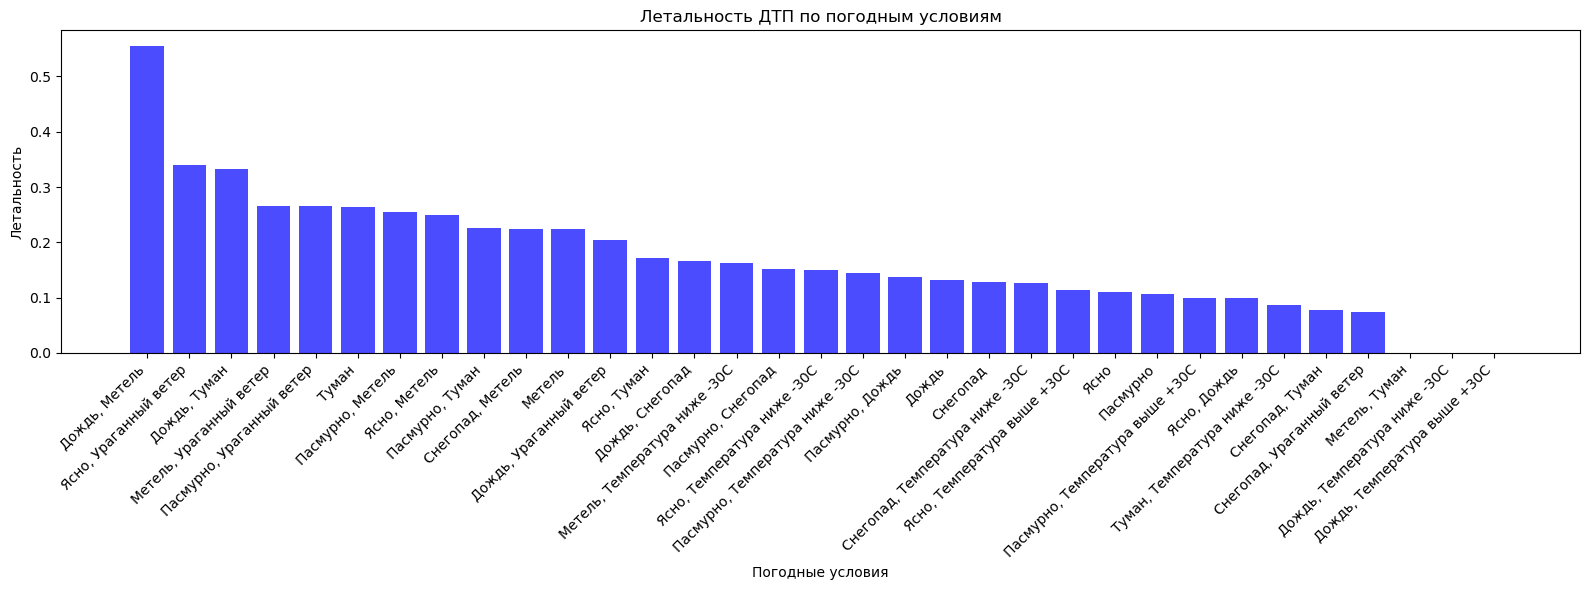

<Figure size 640x480 with 0 Axes>

In [90]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, compute_rate, plot_bar_chart, save_png

# Извлекаем статистику по погоде из SQLite
sql_weather = """
SELECT
  weather,
  COUNT(*)       AS accident_count,
  SUM(dead_count) AS death_count
FROM accidents
GROUP BY weather
"""
weather_stats = run_query(conn, sql_weather)

# Вычисляем летальность = погибших на 1 ДТП
weather_stats = compute_rate(
    df          = weather_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 1
)

# 3a) Гистограмма числа ДТП (по убыванию)
weather_by_count = weather_stats.sort_values('accident_count', ascending=False).reset_index(drop=True)
plot_bar_chart(
    df     = weather_by_count,
    x      = 'weather',
    y      = 'accident_count',
    title  = 'Число ДТП по погодным условиям',
    xlabel = 'Погодные условия',
    ylabel = 'Число ДТП'
)
# Сохраняем последний построенный график
save_png(plt.gcf(), os.path.join(FIG_DIR, 'accidents_by_weather.png'))

# Гистограмма летальности ДТП (по убыванию)
weather_by_rate = weather_stats.sort_values('fatality_rate', ascending=False).reset_index(drop=True)
plot_bar_chart(
    df     = weather_by_rate,
    x      = 'weather',
    y      = 'fatality_rate',
    title  = 'Летальность ДТП по погодным условиям',
    xlabel = 'Погодные условия',
    ylabel = 'Летальность'
)
save_png(plt.gcf(), os.path.join(FIG_DIR, 'fatality_by_weather.png'))

## Выводы

- **Число ДТП по погодным условиям**:
  - Более 50% аварий — в ясную погоду.
  - Значительная доля — в пасмурную погоду.
  - Меньшинство — во время осадков (из-за их короткой продолжительности).
- **Опасные условия с точки зрения летальности**:
  - Осадки и сильный ветер лидируют по смертности.

## Распределение числа участников ДТП (до 20 участников)

В этом блоке мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить число аварий в разрезе `participants_count`;
- Фильтруем результаты, оставляя только случаи с менее чем 21 участником;
- Строим статическую гистограмму через `plot_bar_chart` из `utils.py`;
- Сохраняем рисунок в папку `figures/`.

Query returned 55 rows


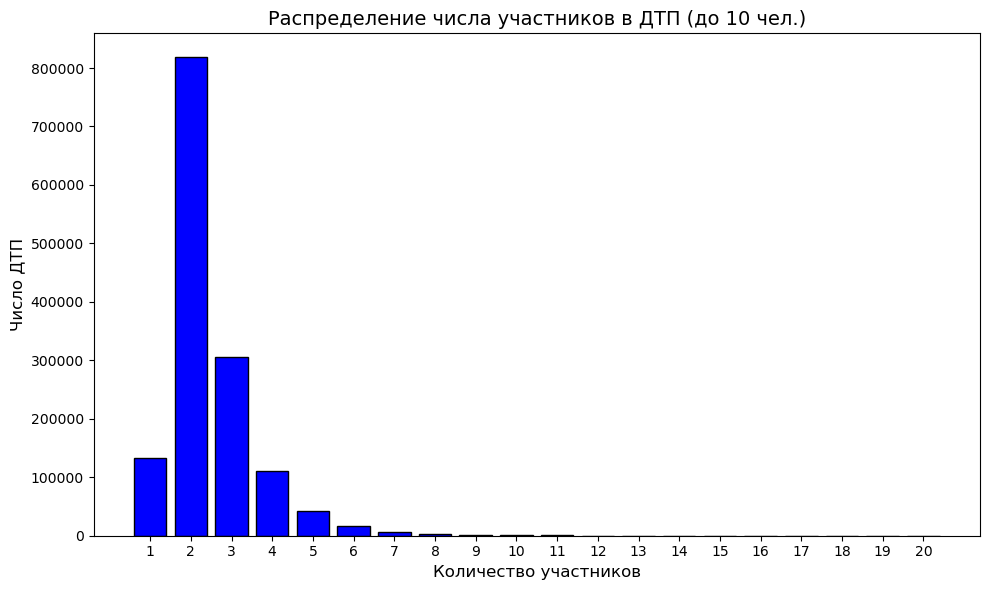

In [105]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, plot_bar_chart, save_png

# Извлекаем из SQLite число ДТП по числу участников
sql = """
SELECT
  participants_count,
  COUNT(*) AS accident_count
FROM accidents
GROUP BY participants_count
"""
participants_stats = run_query(conn, sql)

# Фильтруем до 20 участников и сортируем
participants_stats = (
    participants_stats
    .loc[participants_stats["participants_count"] < 21]
    .sort_values("participants_count")
    .reset_index(drop=True)
)

# Рисуем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    participants_stats['participants_count'],
    participants_stats['accident_count'],
    color='blue',
    edgecolor='black'
)

# Остальная настройка
ax.set_xlabel('Количество участников', fontsize=12)
ax.set_ylabel('Число ДТП', fontsize=12)
ax.set_title('Распределение числа участников в ДТП (до 10 чел.)', fontsize=14)
ax.set_xticks(participants_stats['participants_count'])
ax.grid(False)
plt.tight_layout()
plt.show()

# Сохраняем рисунок
save_png(fig, os.path.join(FIG_DIR, "participants_distribution.png"))

- **Количество участников ДТП**:
  - Чаще всего — 2 человека.
  - Реже — 3, 1 или 5 человек.
  - ДТП с большим числом участников — редкость.

## Распределение числа погибших в ДТП

В этом блоке мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить количество аварий в разрезе числа погибших (`dead_count`);
- Строим статическую гистограмму через `plot_bar_chart` из `utils.py`;
- Сохраняем итоговый рисунок в папку `figures/`.

Query returned 20 rows


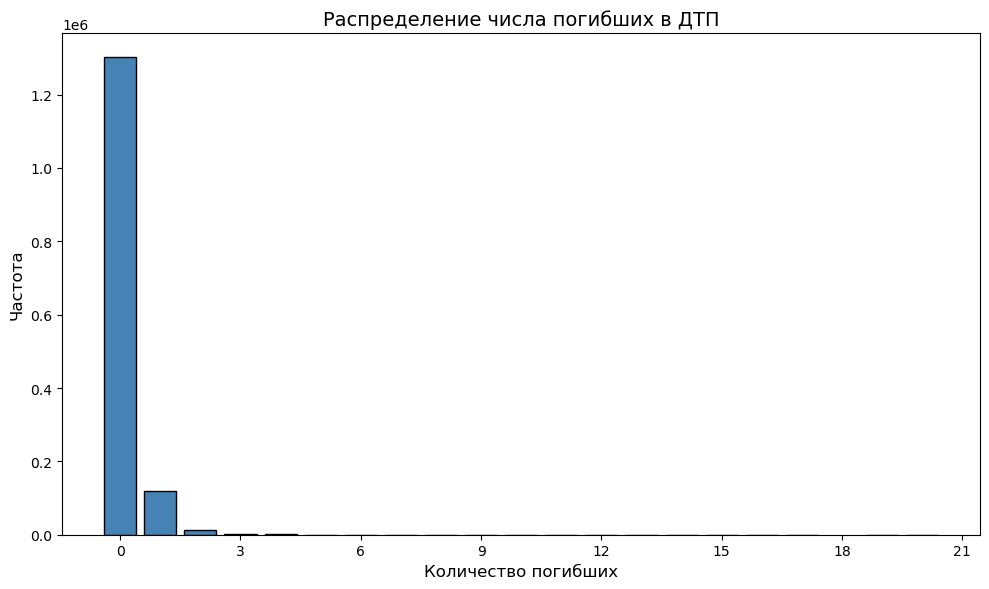

In [107]:
import sys, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from utils import run_query, plot_bar_chart, save_png

# SQL-запрос: распределение по числу погибших
sql_death = """
SELECT
  dead_count,
  COUNT(*) AS frequency
FROM accidents
GROUP BY dead_count
ORDER BY dead_count
"""
death_stats = run_query(conn, sql_death)

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    death_stats["dead_count"],
    death_stats["frequency"],
    color="steelblue",
    edgecolor="black"
)
ax.set_title("Распределение числа погибших в ДТП", fontsize=14)
ax.set_xlabel("Количество погибших", fontsize=12)
ax.set_ylabel("Частота", fontsize=12)

# показываем только целые метки на оси X
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
plt.tight_layout()

# Сохраняем результат
save_png(fig, os.path.join(FIG_DIR, "death_distribution.png"))
plt.show()

## Выводы
- **Смертность в ДТП**:
  - Большинство аварий — без смертельных исходов.
  - ДТП с более чем 1 погибшим — редкость.

## Распределение числа пострадавших в ДТП

Здесь мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить число аварий в разрезе количества раненых (`injured_count`);
- Строим статическую гистограмму через Matplotlib;
- Гарантируем на оси X только целочисленные метки;
- Сохраняем рисунок в папку `figures/`.

Query returned 46 rows


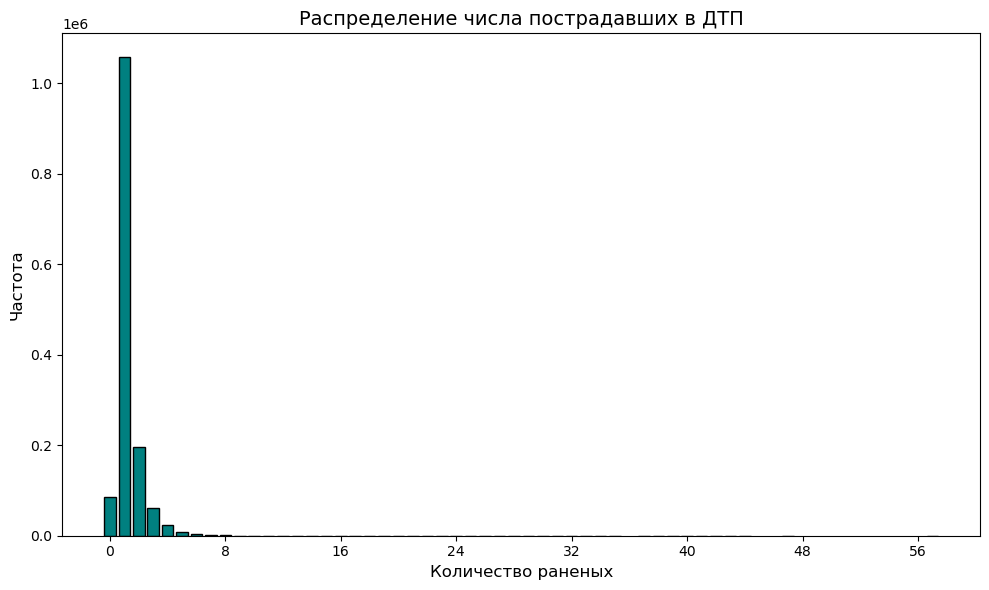

In [110]:
import sys, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from utils import run_query, save_png

# SQL-запрос: распределение по числу раненых
sql_inj = """
SELECT
  injured_count,
  COUNT(*) AS frequency
FROM accidents
GROUP BY injured_count
ORDER BY injured_count
"""
injured_stats = run_query(conn, sql_inj)

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    injured_stats["injured_count"],
    injured_stats["frequency"],
    color="teal",
    edgecolor="black"
)

ax.set_title("Распределение числа пострадавших в ДТП", fontsize=14)
ax.set_xlabel("Количество раненых", fontsize=12)
ax.set_ylabel("Частота", fontsize=12)

# Только целые метки на оси X
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
plt.tight_layout()

# Сохраняем рисунок
save_png(fig, os.path.join(FIG_DIR, "injured_distribution.png"))
plt.show()

## Выводы
- **ДТП по числу раненых** (по данным рисунка 1.Х):
  - Аварии без раненых — редкость (причина — учитываются только ДТП с пострадавшими).
  - Чаще всего — 1 раненый.
  - Реже — 2–4 раненых.
  - Более 4 раненых — крайне редко.

## Аварии с нарушениями

В этом блоке мы:
- Считаем количество ДТП с любыми нарушениями;
- Считаем долю ДТП с нарушениями со стороны водителей;
- Считаем долю ДТП с нарушениями со стороны пешеходов;
- Выводим результаты в процентах.

In [113]:
import sys, os
from utils import run_query

# Общее число уникальных ДТП
total_df = run_query(conn, """
    SELECT COUNT(DISTINCT id) AS total
    FROM accidents
""")
total_accidents = total_df["total"].iloc[0]

# ДТП с любыми нарушениями
viol_total_df = run_query(conn, """
    SELECT COUNT(DISTINCT p.accident_id) AS count
    FROM participants p
    WHERE p.violations IS NOT NULL
""")
viol_total = viol_total_df["count"].iloc[0]

# ДТП с нарушениями со стороны водителя
viol_driver_df = run_query(conn, """
    SELECT COUNT(DISTINCT p.accident_id) AS count
    FROM participants p
    WHERE p.violations IS NOT NULL
      AND p.role = 'Водитель'
""")
viol_driver = viol_driver_df["count"].iloc[0]

# ДТП с нарушениями со стороны пешехода
viol_ped_df = run_query(conn, """
    SELECT COUNT(DISTINCT p.accident_id) AS count
    FROM participants p
    WHERE p.violations IS NOT NULL
      AND p.role = 'Пешеход'
""")
viol_ped = viol_ped_df["count"].iloc[0]

# Вычисляем доли и выводим
percent_with_violation      = viol_total   / total_accidents * 100
percent_driver_violation    = viol_driver  / total_accidents * 100
percent_pedestrian_violation = viol_ped     / total_accidents * 100

print(f"Процент ДТП с нарушениями: {percent_with_violation:.1f}%")
print(f"Процент ДТП с нарушениями со стороны водителя: {percent_driver_violation:.1f}%")
print(f"Процент ДТП с нарушениями со стороны пешехода: {percent_pedestrian_violation:.1f}%")


Query returned 1 rows
Query returned 1 rows
Query returned 1 rows
Query returned 1 rows
Процент ДТП с нарушениями: 98.8%
Процент ДТП с нарушениями со стороны водителя: 89.9%
Процент ДТП с нарушениями со стороны пешехода: 11.6%


## Выводы
- **Нарушения в ДТП**:
  - Общий процент ДТП с нарушениями — 98.8%.
  - Нарушения со стороны водителя — 89.9%.
  - Нарушения со стороны пешехода — 11.6%.
- **При исследовании мер**, направленных на снижение аварийности, необходимо ориентироваться на факторы связанные с водителями

## Анализ ДТП по полу участников и водителей

В этом разделе мы прибегаем к SQL-агрегации в базе SQLite:
- сначала рассчитываем число уникальных ДТП и число погибших для каждого пола **всех участников**;
- затем — то же самое только для участников с ролью «Водитель»;
- с помощью `compute_rate` вычисляем `fatality_rate` = погибших на 100 ДТП;
- выводим две таблицы с результатами.

In [116]:
import sys, os
from IPython.display import display, Markdown
from utils import run_query, compute_rate

# Статистика по полу всех участников
sql_all = """
SELECT
  p.gender,
  COUNT(DISTINCT p.accident_id) AS accident_count,
  SUM(a.dead_count)             AS death_count
FROM participants p
JOIN accidents a
  ON p.accident_id = a.id
WHERE p.gender <> 'none'
GROUP BY p.gender
"""
gender_stats = run_query(conn, sql_all)
gender_stats = compute_rate(
    df          = gender_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# Статистика по полу только водителей
sql_drv = """
SELECT
  p.gender,
  COUNT(DISTINCT p.accident_id) AS accident_count,
  SUM(a.dead_count)             AS death_count
FROM participants p
JOIN accidents a
  ON p.accident_id = a.id
WHERE p.role = 'Водитель'
  AND p.gender <> 'none'
GROUP BY p.gender
"""
driver_stats = run_query(conn, sql_drv)
driver_stats = compute_rate(
    df          = driver_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# Вывод результатов
display(Markdown("### Статистика по полу всех участников"))
display(gender_stats)

display(Markdown("### Статистика по полу только водителей"))
display(driver_stats)


Query returned 2 rows
Query returned 2 rows


### Статистика по полу всех участников

,gender,accident_count,death_count,fatality_rate
0,Женский,776635,124461,16.0
1,Мужской,1332535,371364,27.9


### Статистика по полу только водителей

,gender,accident_count,death_count,fatality_rate
0,Женский,295947,18375,6.2
1,Мужской,1262838,231650,18.3


## Выводы
- **Ключевые различия**:
  - Мужчины чаще участвуют в ДТП и как водители, и как участники.
  - Летальность у мужчин выше: 27.9% (участники) и 18.3% (водители) против 16.0% и 6.2% у женщин.

## Аварии по роли участника

В этом блоке мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить для каждой роли (`role`)  
  число уникальных аварий и суммарное число погибших;
- С помощью `compute_rate` вычисляем летальность (`fatality_rate` = погибших на 100 ДТП);
- Сортируем роли по убыванию числа погибших и выводим итоговую таблицу.

In [119]:
import sys, os
from IPython.display import display, Markdown
from utils import run_query, compute_rate

# SQL-запрос: аварии по роли участника
sql_role = """
SELECT
  p.role,
  COUNT(DISTINCT p.accident_id) AS accident_count,
  SUM(a.dead_count)             AS death_count
FROM participants p
JOIN accidents a
  ON p.accident_id = a.id
GROUP BY p.role
"""
role_stats = run_query(conn, sql_role)

# вычисляем fatality_rate = погибших на 100 ДТП
role_stats = compute_rate(
    df          = role_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# сортируем по убыванию числа погибших
role_stats = role_stats.sort_values('death_count', ascending=False).reset_index(drop=True)

# выводим результат
display(Markdown("### Аварии по роли участника"))
display(role_stats)

Query returned 5 rows


### Аварии по роли участника

,role,accident_count,death_count,fatality_rate
0,Водитель,1427609,255382,17.9
1,Пассажир,546037,198254,36.3
2,Пешеход,418542,48723,11.6
3,Велосипедист,48510,3443,7.1
4,"Пешеход, перед ДТП находившийся в (на) ТС в ка...",6552,1789,27.3


## Выводы
- **Участники ДТП**:
  - Чаще всего — водители.
  - Реже — пассажиры и пешеходы.
  - Реже всего — велосипедисты и люди, вышедшие из транспортного средства.
- **Смертность по категориям**:
  - Наибольшая летальность — у аварий с участием пассажиров.
  - Наименьшая летальность — у аварий с участием велосипедистов.

## ДТП по виду транспортного средства

Здесь мы:
- Выполняем SQL-запрос к базе SQLite, чтобы получить число уникальных ДТП по каждому типу ТС;
- Отбираем топ-10 типов ТС по числу аварий;
- Выводим таблицу с результатами и строим гистограмму через `plot_bar_chart` из `utils.py`;
- Сохраняем итоговый график в папку `figures/`.

Query returned 10 rows


### Топ-10 видов транспортных средств по числу ДТП

,vehicle_type,accident_count
0,"В-класс (малый) до 3,9 м",643605
1,"С-класс (малый средний, компактный) до 4,3 м",323165
2,"D-класс (средний) до 4,6 м",141903
3,Прочие легковые автомобили,134919
4,Мотоциклы,69917
5,Минивэны и универсалы повышенной вместимости,66932
6,Седельные тягачи,58634
7,Фургоны,53087
8,"А-класс (особо малый) до 3,5 м",52286
9,Велосипеды,49401


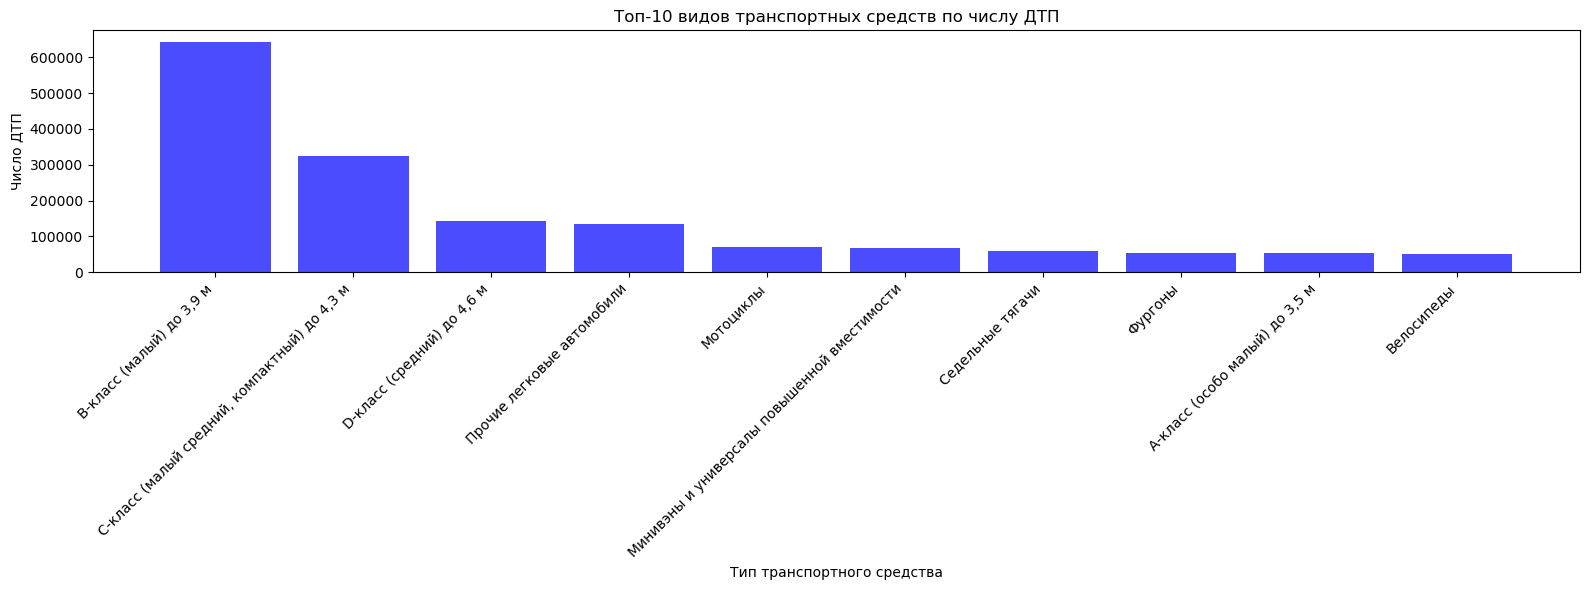

In [134]:
import sys, os
from IPython.display import display, Markdown
from utils import run_query, plot_bar_chart, save_png

# SQL-запрос: число ДТП по видам ТС
sql = """
SELECT
  v.category AS vehicle_type,
  COUNT(DISTINCT v.accident_id) AS accident_count
FROM vehicles v
GROUP BY v.category
ORDER BY accident_count DESC
LIMIT 10
"""
top_vehicles = run_query(conn, sql)

# Выводим таблицу топ-10
display(Markdown("### Топ-10 видов транспортных средств по числу ДТП"))
display(top_vehicles)

# Строим диаграмму
plot_bar_chart(
    df     = top_vehicles,
    x      = 'vehicle_type',
    y      = 'accident_count',
    title  = 'Топ-10 видов транспортных средств по числу ДТП',
    xlabel = 'Тип транспортного средства',
    ylabel = 'Число ДТП'
)

# Сохраняем результат
save_png(fig, os.path.join(FIG_DIR, "top10_vehicle_types.png"))

## Выводы
- **Топ типов ТС в ДТП**:
  - Лидеры: В-класс (до 3.9 м) — 64,360 ДТП, С-класс (до 4.3 м).
  - Высокие показатели: D-класс (до 4.6 м) и легковые авто.
  - Меньше всего: велосипеды.
- **Ключевые категории**:
  - Легковые авто (В, С, D-класс) доминируют из-за их распространенности.
  - Мотоциклы и грузовики — заметная доля, но меньше.

## Летальность ДТП в зависимости от возраста транспортного средства

В этом блоке мы:
- Через SQL вычисляем возраст ТС как разницу между годом аварии и годом выпуска;
- Группируем по возрасту и считаем число уникальных ДТП и суммарное число погибших;
- С помощью `compute_rate` рассчитываем `fatality_rate` = погибших на 100 ДТП;
- Ограничиваем возраст ТС 50 годами, строим линейный график с маркерами и сохраняем результат в PNG.

Query returned 105 rows


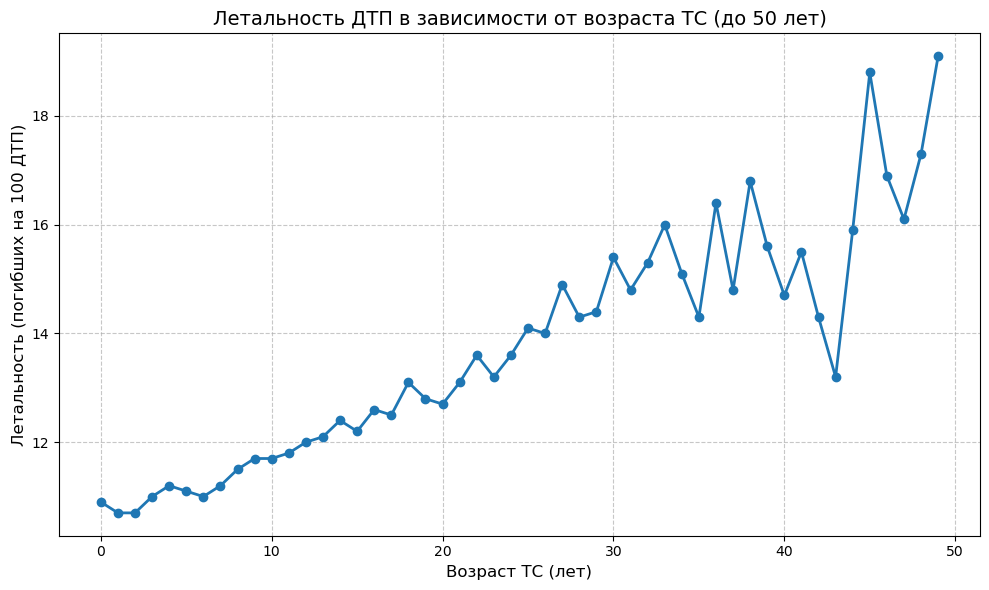

In [125]:
import sys, os
import matplotlib.pyplot as plt
from utils import run_query, compute_rate, save_png

# SQL: агрегируем по возрасту ТС
sql_age = """
SELECT
  CAST(strftime('%Y', a.datetime) AS INTEGER) - v.year AS car_age,
  COUNT(DISTINCT a.id)                                    AS accident_count,
  SUM(a.dead_count)                                       AS death_count
FROM accidents a
JOIN vehicles v
  ON a.id = v.accident_id
GROUP BY car_age
ORDER BY car_age
"""
age_stats = run_query(conn, sql_age)

# Фильтруем возраст до 50 лет
age_stats = age_stats[age_stats["car_age"] < 50].reset_index(drop=True)

# Рассчитываем fatality_rate = погибших на 100 ДТП
age_stats = compute_rate(
    df          = age_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# 4) Строим линейный график с маркерами
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    age_stats['car_age'],
    age_stats['fatality_rate'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=6
)
ax.set_title('Летальность ДТП в зависимости от возраста ТС (до 50 лет)', fontsize=14)
ax.set_xlabel('Возраст ТС (лет)', fontsize=12)
ax.set_ylabel('Летальность (погибших на 100 ДТП)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Сохраняем итоговый график
save_png(fig, os.path.join(FIG_DIR, 'fatality_vs_car_age.png'))
plt.show()

## Выводы
- **Зависимость ДТП от возраста ТС**:
  - Аварийность растет с возрастом: минимальна у новых ТС (до 5 лет).
  - Пик числа ДТП — у ТС старше 40 лет.
  - Колебания: резкие скачки на некоторых возрастах связано с малым количеством ТС такого возраста.